# Sensor Based Phone Activity Recognition

In [ ]:
### Importing libraries

In [133]:
#Feel free to add any libraries you need to here
import numpy as np
from sklearn.model_selection import GroupKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.io.wavfile as wavfile
from scipy import signal

import pandas as pd
# df = pandas.read_csv('hrdata.csv')
# print(df)

%matplotlib inline

## Loads the sensor data from numpy files.
### First, manually filter each CSV to remove any rows where Light > 100, to ensure that the data is only from when phone was in pocket.

In [134]:
# Going down stairs
filename1 = 'down/Sensor_record_20190905_065419_AndroSensor.csv'

# Going up stairs
filename2 = 'up/Sensor_record_20190910_113934_AndroSensor.csv'

# Standing up from sitting position
filename3 = 'stand-up/Sensor_record_20191110_145555_AndroSensor.csv'

# Walking
filename4 = 'walking/walking_ignore_last_2_min.csv'

# Using Elliptical
filename5 = 'elliptical/Sensor_record_20191109_123204_AndroSensor.csv'

import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert an index num to CSV parsable column name
# stolen from https://levelup.gitconnected.com/best-way-to-read-specific-columns-from-csv-in-pandas-7e58507171b3
def colnum_string(n):
    """Convert number to string like: 1->A, 2->AA"""
    string = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

# target_cols = [colnum_string(i) for i in [1, 2, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]]

# indexing base 0
target_columns = [0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]

data = pd.read_csv("stand/Sensor_record_20191110_145555_AndroSensor.csv", header = 0)

print(np.std(data[['ACCELEROMETER X (m/s¬≤)']]).to_numpy())

# ROWS TO EXTRACT:
# ACCELEROMETER X (m/s¬≤) - 1
# ACCELEROMETER Y (m/s¬≤) - 2
# ACCELEROMETER Z (m/s¬≤) - 3
# LINEAR ACCELERATION X (m/s¬≤) - 7
# LINEAR ACCELERATION Y (m/s¬≤) - 8
# LINEAR ACCELERATION Z (m/s¬≤) - 9
# GYROSCOPE X (rad/s) - 10 
# GYROSCOPE Y (rad/s) - 11
# GYROSCOPE Z (rad/s) - 12
# MAGNETIC FIELD X (ŒºT) - 14
# MAGNETIC FIELD Y (ŒºT) - 15
# MAGNETIC FIELD Z (ŒºT) - 16
# ORIENTATION Z (azimuth ¬∞) - 17 
# ORIENTATION X (pitch ¬∞) - 18
# ORIENTATION Y (roll ¬∞) - 19

[0.60886482]



## Build up X & Y np Arrays 

In [128]:
from os import listdir
from os.path import isfile, join
import os

data= []
categories = []
minLength = 100000000;

target_columns = [0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]

stand = [os.path.join(pth, f) 
    for pth, dirs, files in os.walk("stand") for f in files]
up = [os.path.join(pth, f) 
    for pth, dirs, files in os.walk("up") for f in files]
down = [os.path.join(pth, f) 
    for pth, dirs, files in os.walk("down") for f in files]
walk = [os.path.join(pth, f) 
    for pth, dirs, files in os.walk("walk") for f in files]
elliptical = [os.path.join(pth, f) 
    for pth, dirs, files in os.walk("elliptical") for f in files]
# get min size of all arrays 
def getMinArray(directory):
    global minLength
    for dir in (directory):
        file = dir
        fs,y=wavfile.read(file)
        length = len(y)
        if length < minLength:
            minLength = length;


test_cols = [colnum_string(i) for i in [0, 1, 2, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]]
            
# Pre-processing - standardize the length of each array to be the length of the smallest audio clip
def buildArray(directory, name):
    for dir in (directory):
        file = dir
        print(file)
        if file[-3:] != "csv":
            print('Unsupported File Format')
            break
        fileData = pd.read_csv(str(file), header = 0)
        print(fileData[['ACCELEROMETER X (m/s¬≤)']])
        data.append(fileData)
        categories.append(float(name))

# getMinArray(stand)
# getMinArray(up)
# getMinArray(down)
# getMinArray(walk)
# getMinArray(elliptical)
                
buildArray(stand, "1")
buildArray(up, "2")
buildArray(down, "3")
buildArray(walk, "4")
buildArray(elliptical, "5")

print(data)
print(categories)

stand/.DS_Store
Unsupported File Format
up/Sensor_record_20190920_102135_AndroSensor.csv
     ACCELEROMETER X (m/s¬≤)
0                     0.7482
1                     0.3998
2                     2.7029
3                     1.7609
4                     8.0753
..                       ...
227                   0.9421
228                   2.6239
229                   0.3316
230                  -3.8330
231                   5.6740

[232 rows x 1 columns]
up/Sensor_record_20190923_175946_AndroSensor.csv
    ACCELEROMETER X (m/s¬≤)
0                   -3.1219
1                    4.2902
2                    0.6021
3                    3.1243
4                    3.7288
5                    3.5421
6                    6.4820
7                    8.9731
8                    2.9160
9                    4.6290
10                   1.3479
11                  10.8189
12                   0.6464
13                   7.4564
14                  11.6497
15                   9.5237
16            

## Featurization function

In [132]:
# Featurize each subject's gaze trajectory in the file
# This method is run once for each video file for each condition

def featurize_input(X, Y, window):
    out = []
    # Where i is each subject in the file
    for i in range(len(X)):
        X_cord = X[i]
        Y_cord = Y[i]
        fv = []
            
        if window == True:
            f,t,pxx = signal.spectrogram(X_cord, fs=16000, nperseg=128, noverlap=64)
            arrs = [
                pxx[:, 0:923],
                pxx[:, 924:1847],
                pxx[:, 1848:2770],
                pxx[:, 2771:3693],
                pxx[:, 3694:4616],
                pxx[:, 4617:5539],
                pxx[:, 5540:6462],
                pxx[:, 6463:7386]    
            ]

            for arr in arrs:
                fv.append(np.max(arr))
                fv.append(np.min(arr))
                fv.append(np.std(arr))
                out.append(fv)
        else:
            fv.append(np.std(X_cord[['ACCELEROMETER Y (m/s¬≤)']]).to_numpy())
            fv.append(np.std(X_cord[['ACCELEROMETER Z (m/s¬≤)']]).to_numpy())
            out.append(fv)
    
    out = np.array(out)
    print(out.shape)
    return out

# featurizedWindowedData = featurize_input(data, categories, True)
featurizedData = featurize_input(data, categories, False)

def bin_input(X, Y, window):
    out = []
    # Where i is each recording
    for i in range(len(X)):
        X_cord = X[i]
        Y_cord = Y[i]
            
        if window == True:
            f,t,pxx = signal.spectrogram(X_cord, fs=16000, nperseg=128, noverlap=64)
            arrs = [
                pxx[:, 0:923],
                pxx[:, 924:1847],
                pxx[:, 1848:2770],
                pxx[:, 2771:3693],
                pxx[:, 3694:4616],
                pxx[:, 4617:5539],
                pxx[:, 5540:6462],
                pxx[:, 6463:7386]    
            ]
    
            for arr in arrs:
                binned = cv2.resize(arr[:,:],(num_time_bins,num_freq_bins))
                out.append(binned.flatten())

        else:
            f,t,pxx = signal.spectrogram(X_cord, fs=16000, nperseg=1024, noverlap=512)
            
            binned = cv2.resize(pxx[:,:],(num_time_bins,num_freq_bins))

            out.append(binned.flatten())
    
    out = np.array(out)
    print(out.shape)
    return out

# binnedWindowed = bin_input(data, categories, True)
# binnedUnwindowed = bin_input(data, categories, False)

[4.05138816]
(5, 4, 1)


## Approach 1: Train the set on 30 second windows, no binning, and use contextual featurization

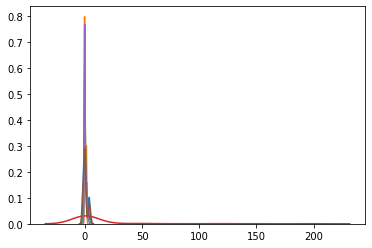

In [186]:
scaler = RobustScaler()
X = np.asarray(featurizedData)
X = scaler.fit_transform(X)
Y = categories
import seaborn as sns
for i in range(X.shape[1]):
    sns.kdeplot(X[:,i])

## Setting up the variables to run the classifier

In [187]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [188]:
scores = []
clf = SVC(kernel='rbf', gamma="auto", C=20) 

for train_index, test_index in cv.split(X):
#     print("Train Index: ", train_index)
#     print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = np.asarray(X)[train_index], np.asarray(X)[test_index], np.asarray(Y)[train_index], np.asarray(Y)[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

print("Mean accuracy:" + str(np.mean(scores)))

Mean accuracy:0.9083333333333334


## Approach 2: Train the set on 1/8th size windows, no binning, and use contextual featurization

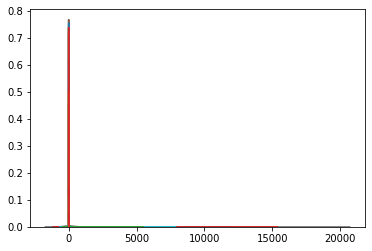

In [189]:
scaler = RobustScaler()
X = np.asarray(featurizedWindowedData)
X = scaler.fit_transform(X)
import seaborn as sns
for i in range(X.shape[1]):
    sns.kdeplot(X[:,i])

## Setting up the variables to run the classifier

In [190]:
arr = []

for i in range(120):
    arr.append(np.full((8), i))

groups = np.asarray(arr).flatten()

categoriesArr = []

for i in range(6):
    categoriesArr.append(np.full((160), float(i)))
    
updatedCategories = np.asarray(categoriesArr).flatten()

Y = updatedCategories;

cv = GroupKFold(n_splits=6)
cv.get_n_splits(X, updatedCategories, groups)

6

In [191]:
scores = []
clf = SVC(kernel='linear', gamma="auto", C=1000) 

for train_index, test_index in cv.split(X, Y, groups):
#     print("Train Index: ", train_index)
#     print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = np.asarray(X)[train_index], np.asarray(X)[test_index], np.asarray(Y)[train_index], np.asarray(Y)[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

    
print("Mean accuracy:" + str(np.mean(scores)))

Mean accuracy:0.9416666666666668


## Approach 3: Train the set on 30 second windows, WITH binning

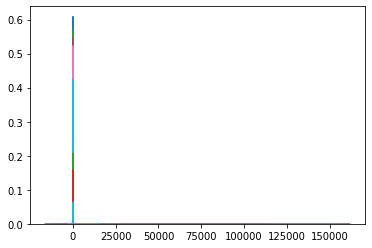

In [170]:
scaler = RobustScaler()
X = np.asarray(binnedUnwindowed)
X = scaler.fit_transform(X)
Y = categories
import seaborn as sns
for i in range(X.shape[1]):
    sns.kdeplot(X[:,i])

## Setting up the variables to run the classifier

In [171]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [172]:
scores = []
clf = SVC(kernel='linear', gamma="auto", C=20000) 

for train_index, test_index in cv.split(X):
#     print("Train Index: ", train_index)
#     print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = np.asarray(X)[train_index], np.asarray(X)[test_index], np.asarray(Y)[train_index], np.asarray(Y)[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

print("Mean accuracy:" + str(np.mean(scores)))

Mean accuracy:0.9166666666666666


## Approach 4: Train the set on 1/8th size windows, WITH binning

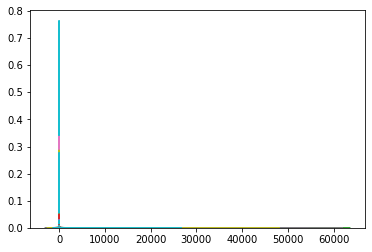

In [173]:
scaler = RobustScaler()
X = np.asarray(binnedWindowed)
X = scaler.fit_transform(X)
import seaborn as sns
for i in range(X.shape[1]):
    sns.kdeplot(X[:,i])

## Setting up the variables to run the classifier

In [175]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

arr = []

for i in range(120):
    arr.append(np.full((8), i))
    
groups = np.asarray(arr).flatten()

categoriesArr = []

for i in range(6):
    categoriesArr.append(np.full((160), float(i)))
    
updatedCategories = np.asarray(categoriesArr).flatten()

Y = updatedCategories;

cv = GroupKFold(n_splits=6)
cv.get_n_splits(X, updatedCategories, groups)

6

In [176]:
scores = []
clf = SVC(kernel='linear', gamma="auto", C=20000) 

for train_index, test_index in cv.split(X, Y, groups):
#     print("Train Index: ", train_index)
#     print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = np.asarray(X)[train_index], np.asarray(X)[test_index], np.asarray(Y)[train_index], np.asarray(Y)[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

print("Mean accuracy:" + str(np.mean(scores)))

Mean accuracy:0.959375


## Writeup

This process was fairly difficult to first get started on. I first started by trying to visualize every class individually, just to get a sense for the data. It then took a little while to figure out the high level process, and what deliverables the assignment called for. Going to office hours was pretty useful and helped jumpstart my process.  

Once I was able to sort the code out, it was clear that feature selection would be the single most effective factor in correct classification. Comparing windowing to non-windowing, it's clear that windowing the data is more effective in getting samples that have diverse characteristics. This requires the model to more accruately gauge acoustic qualia in the frequency domain. Unwindowed samples are naturally more obscure and require the computer to make decisions based on a whole array. In terms of practicality, it makes sense that windowing the samples is more ecologically sound and leads to higher performance - it's unlikely that audio samples in the real world can be heard in their entirety, without interruption or other noises. 

In terms of binning, it seems like binning could be useful in the event that contextual featurization is unintuitive or difficult to discern. Binning seems like a more elementary form of deep-learning, where the features are the data themselves, just more generalized and averaged across the bins. I prefer contextual featurization, since we had the added benefit of reading the provided papers where they provided insights for us on the best features to extract in the frequency and time domains. Had we not had this data, or the ability to research effective features, binning would be a viable tactic.

I'm slightly concerned that my data is overfitted, as some of the performance metrics gathered seem too good to be true. However, I know that I correctly separated and grouped my data, so I don't know what other factors would lead to overfitting. I do know that spectral qualities like no. peaks and spectral centroid are powerful features. When I printed them out, it was pretty clear just from those two data points that each class was drastically different, by entire orders of magnitude in some cases. 

Overall, this was a pretty cool test of our abilities and I'm glad I got the chance to do this on my own data. Thanks for the opportunity! Please roast me and tell me how to make this better, as I'm frankly not entirely confident that I did this according to protocol. I'd love to improve and learn! 